# YOLO Model Inference on Validation Data

This notebook loads the trained YOLO model and runs inference on validation images to evaluate performance.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from ultralytics import YOLO
import torch

# Set up paths
PROJECT_ROOT = Path('..')
MODEL_PATH = PROJECT_ROOT / 'runs' / 'detect' / 'train2' / 'weights' / 'last.pt'
VAL_IMAGES_PATH = PROJECT_ROOT / 'data' / 'processed' / 'images' / 'val'
VAL_LABELS_PATH = PROJECT_ROOT / 'data' / 'processed' / 'labels' / 'val'

print(f"Model path: {MODEL_PATH}")
print(f"Model exists: {MODEL_PATH.exists()}")
print(f"Validation images path: {VAL_IMAGES_PATH}")
print(f"Validation labels path: {VAL_LABELS_PATH}")

Model path: ../runs/detect/train2/weights/last.pt
Model exists: True
Validation images path: ../data/processed/images/val
Validation labels path: ../data/processed/labels/val


In [2]:
# Load the trained YOLO model
model = YOLO(str(MODEL_PATH))
print(f"Model loaded successfully!")
print(f"Model device: {model.device}")
print(f"Model names: {model.names}")

Model loaded successfully!
Model device: cpu
Model names: {0: 'person', 1: 'bib', 2: 'dog', 3: 'stroller'}


In [3]:
# Get list of validation images that have corresponding labels
label_files = list(VAL_LABELS_PATH.glob('*.txt'))
image_files_with_labels = []

for label_file in label_files:
    image_name = label_file.stem + '.jpg'
    image_path = VAL_IMAGES_PATH / image_name
    if image_path.exists():
        image_files_with_labels.append(image_path)

print(f"Found {len(image_files_with_labels)} validation images with labels")
print(f"Sample images: {[f.name for f in image_files_with_labels[:5]]}")

Found 27 validation images with labels
Sample images: ['frame_00774.jpg', 'frame_00798.jpg', 'frame_00799.jpg', 'frame_00845.jpg', 'frame_00918.jpg']


In [4]:
def load_yolo_labels(label_path, img_width, img_height):
    """Load YOLO format labels and convert to pixel coordinates"""
    labels = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * img_width
                    y_center = float(parts[2]) * img_height
                    width = float(parts[3]) * img_width
                    height = float(parts[4]) * img_height
                    
                    # Convert to x1, y1, x2, y2
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    labels.append({
                        'class_id': class_id,
                        'bbox': [x1, y1, x2, y2],
                        'center': [x_center, y_center],
                        'size': [width, height]
                    })
    return labels

def draw_bboxes(image, predictions, ground_truth, class_names):
    """Draw bounding boxes on image"""
    img_copy = image.copy()
    
    # Draw ground truth in green
    for gt in ground_truth:
        x1, y1, x2, y2 = [int(coord) for coord in gt['bbox']]
        class_name = class_names.get(gt['class_id'], f"Class {gt['class_id']}")
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_copy, f"GT: {class_name}", (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Draw predictions in red
    if predictions is not None and len(predictions.boxes) > 0:
        boxes = predictions.boxes.xyxy.cpu().numpy()
        classes = predictions.boxes.cls.cpu().numpy()
        confidences = predictions.boxes.conf.cpu().numpy()
        
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = [int(coord) for coord in box]
            class_name = class_names.get(int(cls), f"Class {int(cls)}")
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(img_copy, f"Pred: {class_name} ({conf:.2f})", (x1, y2+20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
    return img_copy

In [40]:
predictions.boxes.cls

tensor([0., 1.])

In [42]:
predictions.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 1.])
conf: tensor([0.9033, 0.7768])
data: tensor([[2.0203e+03, 8.6006e+02, 2.4529e+03, 2.0410e+03, 9.0326e-01, 0.0000e+00],
        [2.2253e+03, 1.2547e+03, 2.3596e+03, 1.3798e+03, 7.7682e-01, 1.0000e+00]])
id: None
is_track: False
orig_shape: (2160, 3840)
shape: torch.Size([2, 6])
xywh: tensor([[2236.5637, 1450.5071,  432.6085, 1180.8893],
        [2292.4312, 1317.2061,  134.3093,  125.1097]])
xywhn: tensor([[0.5824, 0.6715, 0.1127, 0.5467],
        [0.5970, 0.6098, 0.0350, 0.0579]])
xyxy: tensor([[2020.2594,  860.0625, 2452.8679, 2040.9518],
        [2225.2766, 1254.6511, 2359.5859, 1379.7609]])
xyxyn: tensor([[0.5261, 0.3982, 0.6388, 0.9449],
        [0.5795, 0.5809, 0.6145, 0.6388]])

Running inference on 6 sample images...

frame_00916.jpg:
  Ground truth: 2 objects
  Predictions: 3 objects
    1. person (confidence: 0.896)
    2. bib (confidence: 0.464)
    3. bib (confidence: 0.300)

frame_00774.jpg:
  Ground truth: 2 objects
  Predictions: 2 objects
    1. person (confidence: 0.852)
    2. bib (confidence: 0.775)

frame_00974.jpg:
  Ground truth: 3 objects
  Predictions: 7 objects
    1. person (confidence: 0.905)
    2. person (confidence: 0.879)
    3. person (confidence: 0.866)
    4. person (confidence: 0.822)
    5. person (confidence: 0.522)
    6. bib (confidence: 0.425)
    7. bib (confidence: 0.351)

frame_00912.jpg:
  Ground truth: 6 objects
  Predictions: 3 objects
    1. person (confidence: 0.875)
    2. person (confidence: 0.825)
    3. bib (confidence: 0.496)

frame_00855.jpg:
  Ground truth: 8 objects
  Predictions: 9 objects
    1. person (confidence: 0.891)
    2. person (confidence: 0.875)
    3. person (confidence: 0.849)
    4. bib (confidenc

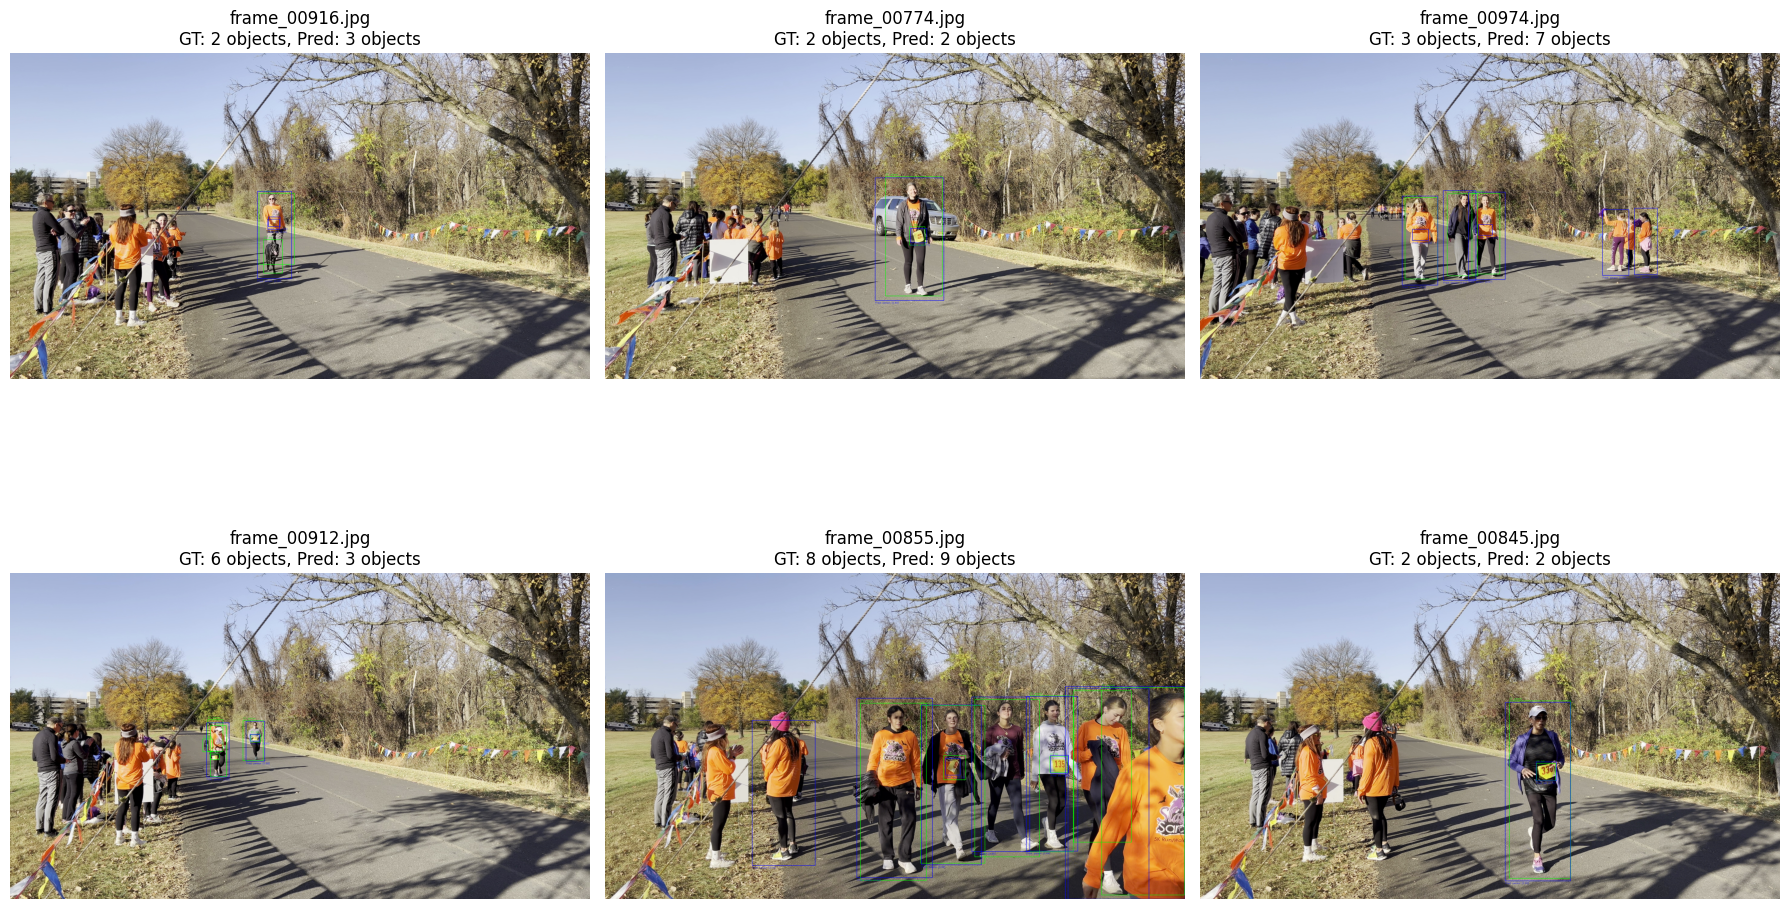

In [39]:
# Select a few random images for inference
num_samples = min(6, len(image_files_with_labels))
sample_images = random.sample(image_files_with_labels, num_samples)

print(f"Running inference on {num_samples} sample images...")

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, image_path in enumerate(sample_images):
    # Load image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load ground truth labels
    label_path = VAL_LABELS_PATH / (image_path.stem + '.txt')
    ground_truth = load_yolo_labels(label_path, img_width, img_height)
    
    # Run inference
    results = model(str(image_path), verbose=False)
    predictions = results[0] if results else None
    
    # Draw bounding boxes
    annotated_image = draw_bboxes(image_rgb, predictions, ground_truth, model.names)
    
    # Display
    axes[idx].imshow(annotated_image)
    axes[idx].set_title(f"{image_path.name}\nGT: {len(ground_truth)} objects, Pred: {len(predictions.boxes) if predictions else 0} objects")
    axes[idx].axis('off')
    
    # Print details
    print(f"\n{image_path.name}:")
    print(f"  Ground truth: {len(ground_truth)} objects")
    if predictions and len(predictions.boxes) > 0:
        print(f"  Predictions: {len(predictions.boxes)} objects")
        for i, (cls, conf) in enumerate(zip(predictions.boxes.cls.cpu().numpy(), predictions.boxes.conf.cpu().numpy())):
            class_name = model.names.get(int(cls), f"Class {int(cls)}")
            print(f"    {i+1}. {class_name} (confidence: {conf:.3f})")
    else:
        print(f"  Predictions: 0 objects")

plt.tight_layout()
plt.show()

In [6]:
# Run inference on all validation images with labels and collect statistics
print("Running inference on all validation images with labels...")

total_gt_objects = 0
total_pred_objects = 0
class_gt_counts = {}
class_pred_counts = {}
confidence_scores = []

for image_path in image_files_with_labels:
    # Load image dimensions
    image = cv2.imread(str(image_path))
    img_height, img_width = image.shape[:2]
    
    # Load ground truth
    label_path = VAL_LABELS_PATH / (image_path.stem + '.txt')
    ground_truth = load_yolo_labels(label_path, img_width, img_height)
    total_gt_objects += len(ground_truth)
    
    # Count ground truth classes
    for gt in ground_truth:
        class_id = gt['class_id']
        class_gt_counts[class_id] = class_gt_counts.get(class_id, 0) + 1
    
    # Run inference
    results = model(str(image_path), verbose=False)
    predictions = results[0] if results else None
    
    if predictions and len(predictions.boxes) > 0:
        total_pred_objects += len(predictions.boxes)
        classes = predictions.boxes.cls.cpu().numpy()
        confidences = predictions.boxes.conf.cpu().numpy()
        
        # Count predicted classes and collect confidence scores
        for cls, conf in zip(classes, confidences):
            class_id = int(cls)
            class_pred_counts[class_id] = class_pred_counts.get(class_id, 0) + 1
            confidence_scores.append(conf)

print(f"\nValidation Set Statistics:")
print(f"Total images processed: {len(image_files_with_labels)}")
print(f"Total ground truth objects: {total_gt_objects}")
print(f"Total predicted objects: {total_pred_objects}")
print(f"\nGround Truth Class Distribution:")
for class_id, count in sorted(class_gt_counts.items()):
    class_name = model.names.get(class_id, f"Class {class_id}")
    print(f"  {class_name}: {count} objects")

print(f"\nPredicted Class Distribution:")
for class_id, count in sorted(class_pred_counts.items()):
    class_name = model.names.get(class_id, f"Class {class_id}")
    print(f"  {class_name}: {count} objects")

if confidence_scores:
    print(f"\nConfidence Score Statistics:")
    print(f"  Mean confidence: {np.mean(confidence_scores):.3f}")
    print(f"  Median confidence: {np.median(confidence_scores):.3f}")
    print(f"  Min confidence: {np.min(confidence_scores):.3f}")
    print(f"  Max confidence: {np.max(confidence_scores):.3f}")

Running inference on all validation images with labels...

Validation Set Statistics:
Total images processed: 27
Total ground truth objects: 113
Total predicted objects: 120

Ground Truth Class Distribution:
  person: 71 objects
  bib: 34 objects
  dog: 8 objects

Predicted Class Distribution:
  person: 79 objects
  bib: 37 objects
  dog: 4 objects

Confidence Score Statistics:
  Mean confidence: 0.715
  Median confidence: 0.823
  Min confidence: 0.253
  Max confidence: 0.988


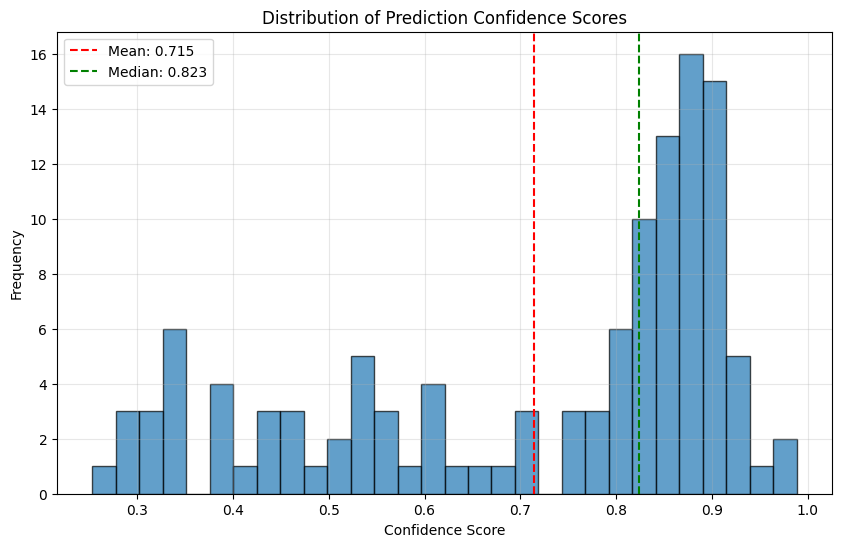

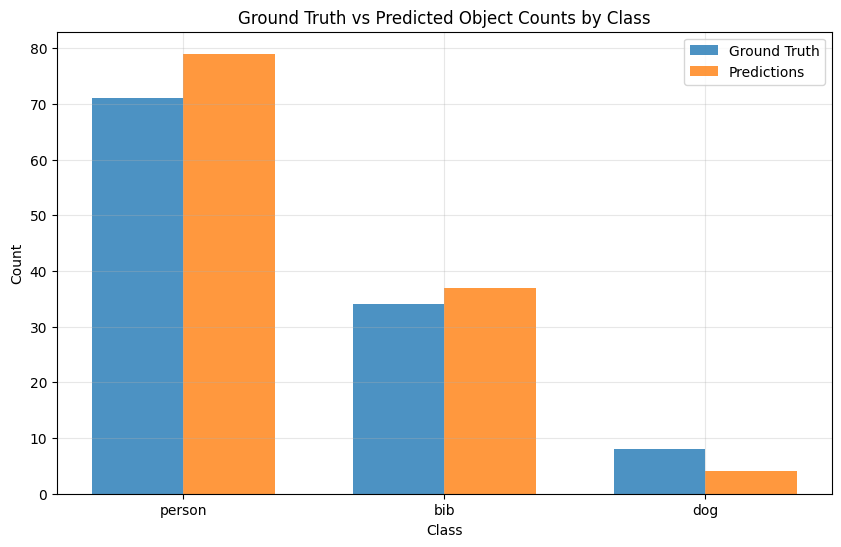

In [7]:
# Plot confidence score distribution
if confidence_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Confidence Scores')
    plt.axvline(np.mean(confidence_scores), color='red', linestyle='--', label=f'Mean: {np.mean(confidence_scores):.3f}')
    plt.axvline(np.median(confidence_scores), color='green', linestyle='--', label=f'Median: {np.median(confidence_scores):.3f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot class distribution comparison
all_classes = set(list(class_gt_counts.keys()) + list(class_pred_counts.keys()))
class_names = [model.names.get(cls, f"Class {cls}") for cls in sorted(all_classes)]
gt_counts = [class_gt_counts.get(cls, 0) for cls in sorted(all_classes)]
pred_counts = [class_pred_counts.get(cls, 0) for cls in sorted(all_classes)]

x = np.arange(len(class_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, gt_counts, width, label='Ground Truth', alpha=0.8)
plt.bar(x + width/2, pred_counts, width, label='Predictions', alpha=0.8)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Ground Truth vs Predicted Object Counts by Class')
plt.xticks(x, class_names)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Detailed analysis for: frame_00799.jpg


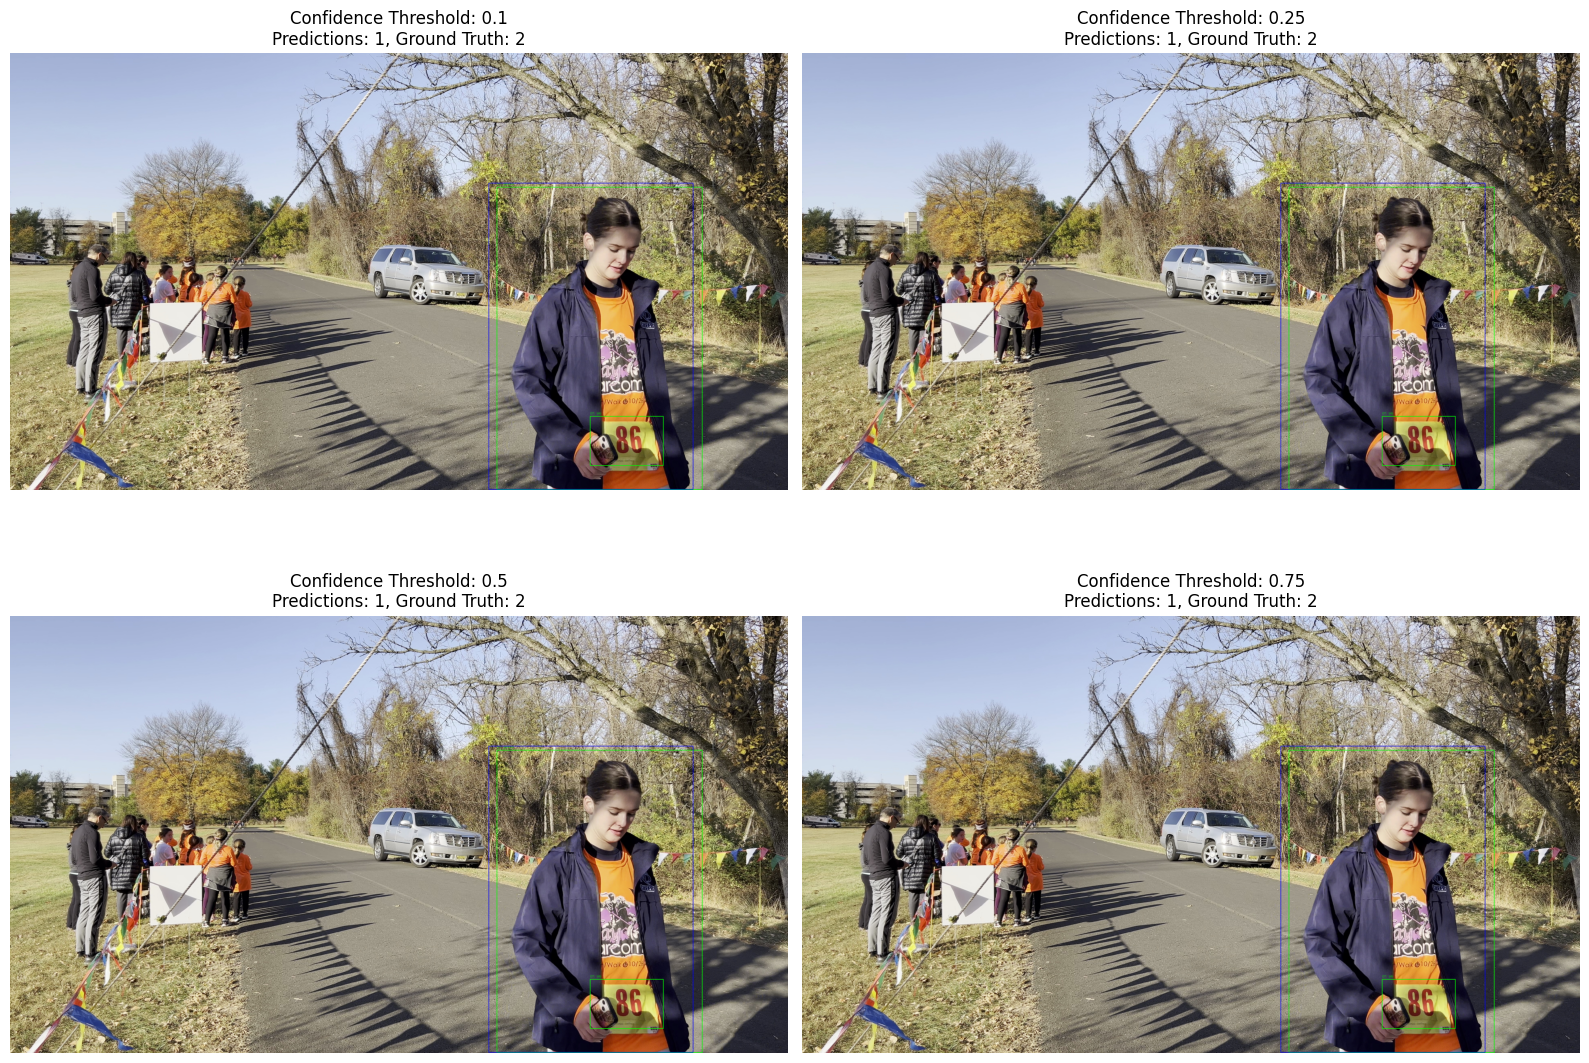


Ground Truth Details:
  1. person at (2909.9, 1412.7) size: 1013.1x1492.6
  2. bib at (3044.2, 1917.9) size: 360.6x242.4


In [138]:
# Run inference on a specific image with detailed analysis
if image_files_with_labels:
    # Select an image with multiple objects
    selected_image = image_files_with_labels[2]  # You can change this index
    
    print(f"Detailed analysis for: {selected_image.name}")
    
    # Load and display original image
    image = cv2.imread(str(selected_image))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load ground truth
    label_path = VAL_LABELS_PATH / (selected_image.stem + '.txt')
    ground_truth = load_yolo_labels(label_path, img_width, img_height)
    
    # Run inference with different confidence thresholds
    conf_thresholds = [0.1, 0.25, 0.5, 0.75]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, conf_thresh in enumerate(conf_thresholds):
        results = model(str(selected_image), conf=conf_thresh, verbose=False)
        predictions = results[0] if results else None
        
        annotated_image = draw_bboxes(image_rgb, predictions, ground_truth, model.names)
        
        axes[idx].imshow(annotated_image)
        pred_count = len(predictions.boxes) if predictions else 0
        axes[idx].set_title(f"Confidence Threshold: {conf_thresh}\nPredictions: {pred_count}, Ground Truth: {len(ground_truth)}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed ground truth information
    print(f"\nGround Truth Details:")
    for i, gt in enumerate(ground_truth):
        class_name = model.names.get(gt['class_id'], f"Class {gt['class_id']}")
        print(f"  {i+1}. {class_name} at ({gt['center'][0]:.1f}, {gt['center'][1]:.1f}) size: {gt['size'][0]:.1f}x{gt['size'][1]:.1f}")

## OCR Analysis on Predicted Bib Numbers

This section crops the predicted bib bounding boxes and applies OCR to read the bib numbers.

In [13]:
# Import OCR libraries
try:
    import pytesseract
    from PIL import Image
    print("OCR libraries loaded successfully")
except ImportError as e:
    print(f"Error importing OCR libraries: {e}")
    print("Please install required packages: pip install pytesseract pillow")
    print("Also ensure tesseract is installed on your system")

OCR libraries loaded successfully


In [ ]:
# # def preprocess_bib_image(image_crop):
# #     """Preprocess cropped bib image for better OCR results"""
# #     # Convert to grayscale
# #     gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    
# #     # Apply Gaussian blur to reduce noise
# #     blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
# #     # Apply adaptive thresholding
# #     thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
# #                                    cv2.THRESH_BINARY, 11, 2)
    
# #     # Apply morphological operations to clean up the image
# #     kernel = np.ones((2, 2), np.uint8)
# #     cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
# #     return cleaned

# def preprocess_bib_image(image_crop):
#     """
#     Applies advanced preprocessing to handle uneven lighting and noise.
#     """
#     # 1. Convert to Grayscale
#     gray = cv2.cvtColor(image_crop, cv2.COLOR_BGR2GRAY)

#     # 2. Apply a bilateral filter to reduce noise while preserving edges.
#     denoised = cv2.bilateralFilter(gray, 9, 75, 75)

#     # 3. Apply Adaptive Thresholding to handle lighting variations.
#     #    cv2.THRESH_BINARY_INV creates black text on a white background.
#     binary_image = cv2.adaptiveThreshold(
#         denoised, 
#         255, 
#         cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#         cv2.THRESH_BINARY_INV,
#         11, # The size of the neighborhood area.
#         4   # A constant subtracted from the calculated mean.
#     )
    
#     return binary_image

# def extract_bib_number(image_crop, min_confidence=30):
#     """Extract bib number from cropped image using OCR"""
#     try:
#         # Preprocess the image
#         processed = preprocess_bib_image(image_crop)
        
#         # Convert to PIL Image
#         pil_image = Image.fromarray(processed)
        
#         # Configure OCR for numbers only
#         custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789'
        
#         plt.imshow(pil_image, cmap='gray')
#         plt.show()
#         # Get OCR data with confidence scores
#         ocr_data = pytesseract.image_to_data(pil_image, config=custom_config, output_type=pytesseract.Output.DICT)
#         print(ocr_data)
#         # Extract text with confidence scores
#         texts = []
#         confidences = []
        
#         for i, text in enumerate(ocr_data['text']):
#             if text.strip() and int(ocr_data['conf'][i]) >= min_confidence:
#                 texts.append(text.strip())
#                 confidences.append(int(ocr_data['conf'][i]))
        
#         if texts:
#             # Return the text with highest confidence
#             best_idx = np.argmax(confidences)
#             return texts[best_idx], confidences[best_idx]
#         else:
#             return None, 0
            
#     except Exception as e:
#         print(f"OCR error: {e}")
#         return None, 0

# def crop_bib_from_prediction(image, bbox, padding=10):
#     """Crop bib region from image with padding"""
#     x1, y1, x2, y2 = [int(coord) for coord in bbox]
    
#     # Add padding
#     x1 = max(0, x1 - padding)
#     y1 = max(0, y1 - padding)
#     x2 = min(image.shape[1], x2 + padding)
#     y2 = min(image.shape[0], y2 + padding)
    
#     return image[y1:y2, x1:x2]

In [146]:
import easyocr

def preprocess_for_easyocr(image_crop):
    """
    Applies a series of preprocessing steps to an image to improve 
    EasyOCR accuracy, focusing on contrast and clarity.
    """
    # TODO: optimize the preprocessing steps.
    # 1. Convert to Grayscale
    gray = cv2.cvtColor(image_crop, cv2.COLOR_BGR2GRAY)
    
    # 2. Apply a bilateral filter for noise reduction while preserving edges.
    # This is effective against the minor noise and blur in your images.
    denoised = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # 3. Binarization using adaptive thresholding
    # This is crucial for handling the glare on "86" and uneven lighting.
    # It creates a clean black-and-white image.
    binary_image = cv2.adaptiveThreshold(
        denoised, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    return binary_image
def extract_bib_with_easyocr(image_crop):
    """
    Extracts bib number using the EasyOCR library.
    """
    try:
        # This line only needs to be run once to load the model
        reader = easyocr.Reader(['en']) 
        
        # Preprocess the image for better OCR results
        # image_crop = preprocess_for_easyocr(image_crop)
        result = reader.readtext(image_crop, allowlist='0123456789')
        
        if result:
            for bbox, text, confidence in result:
                
                return text, confidence
            # # Join the list of detected numbers into a single string
            # bib_number = "".join(result)
            # return bib_number, None
        else:
            return None, None

    except Exception as e:
        print(f"EasyOCR error: {e}")
        return None, None


def crop_bib_from_prediction(image, bbox, padding=10):
    """Crop bib region from image with padding"""
    x1, y1, x2, y2 = [int(coord) for coord in bbox]
    
    # Add padding
    x1 = max(0, x1 - padding)
    y1 = max(0, y1 - padding)
    x2 = min(image.shape[1], x2 + padding)
    y2 = min(image.shape[0], y2 + padding)
    
    return image[y1:y2, x1:x2]

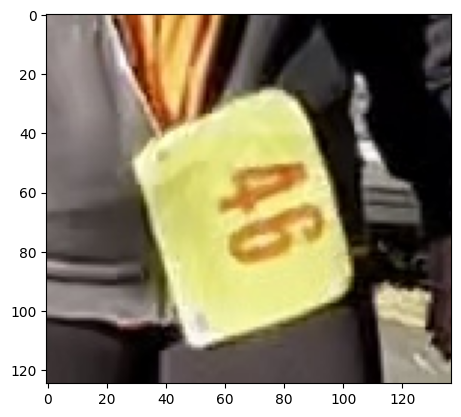

{'image': 'frame_00774.jpg', 'bib_number': '3', 'ocr_confidence': np.float64(0.5243567103889433), 'yolo_confidence': np.float32(0.77473307)}


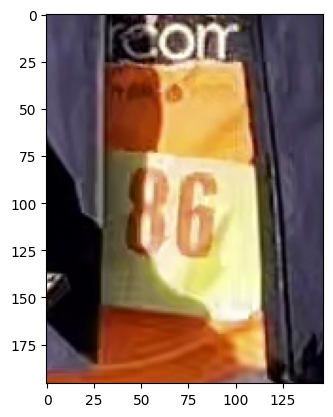

{'image': 'frame_00798.jpg', 'bib_number': '01', 'ocr_confidence': np.float64(0.6198433400613812), 'yolo_confidence': np.float32(0.75058925)}


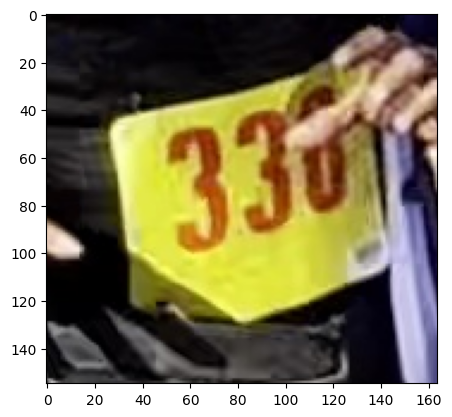

{'image': 'frame_00845.jpg', 'bib_number': '330', 'ocr_confidence': np.float64(0.8222111101666277), 'yolo_confidence': np.float32(0.7768174)}


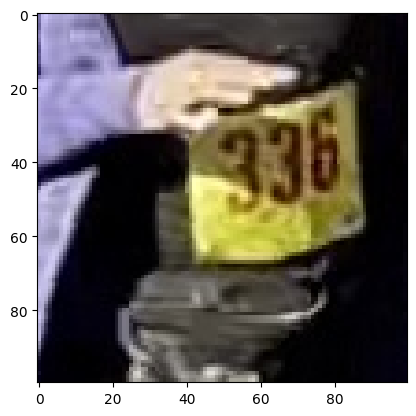

{'image': 'frame_00844.jpg', 'bib_number': '7330', 'ocr_confidence': np.float64(0.375505268573761), 'yolo_confidence': np.float32(0.84423554)}


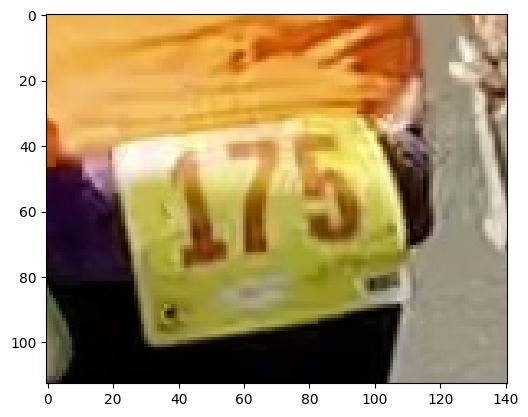

{'image': 'frame_00843.jpg', 'bib_number': '475', 'ocr_confidence': np.float64(0.5174083696334357), 'yolo_confidence': np.float32(0.6114638)}


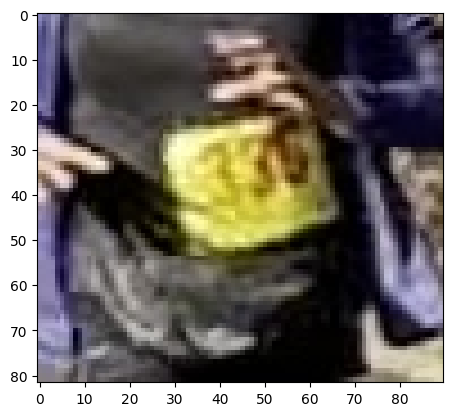

{'image': 'frame_00843.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.5236828)}


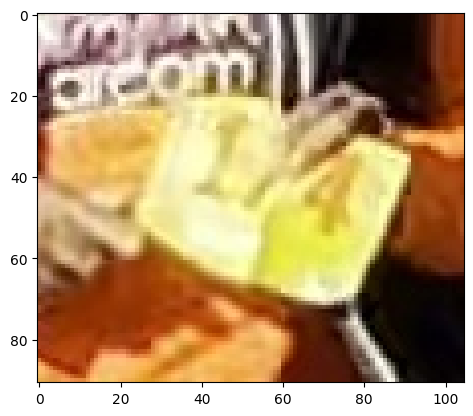

{'image': 'frame_00842.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.6182321)}


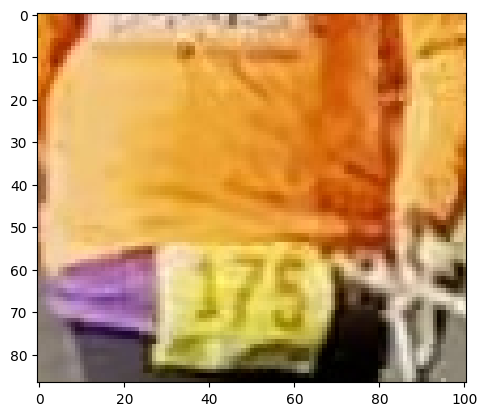

{'image': 'frame_00842.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.44581783)}


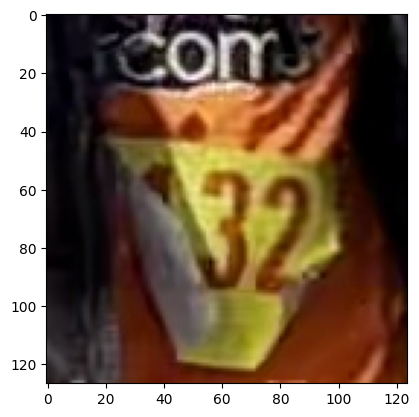

{'image': 'frame_00854.jpg', 'bib_number': '', 'ocr_confidence': np.float64(0.0), 'yolo_confidence': np.float32(0.8813552)}


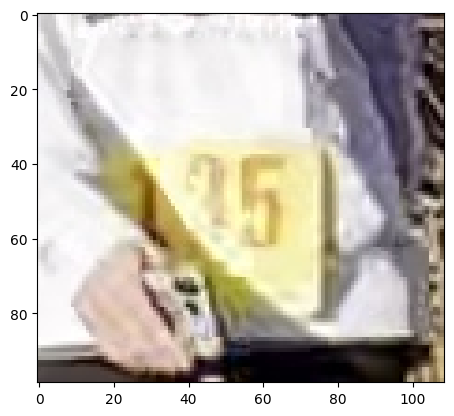

{'image': 'frame_00854.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.7527313)}


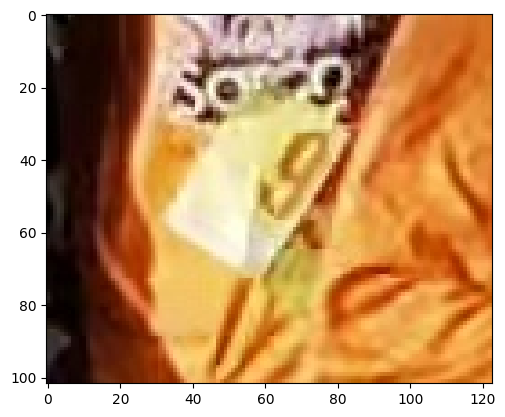

{'image': 'frame_00854.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.42426324)}


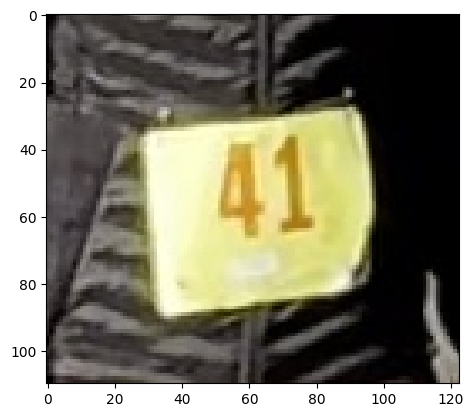

{'image': 'frame_00869.jpg', 'bib_number': '41', 'ocr_confidence': np.float64(0.5903825383563029), 'yolo_confidence': np.float32(0.9166468)}


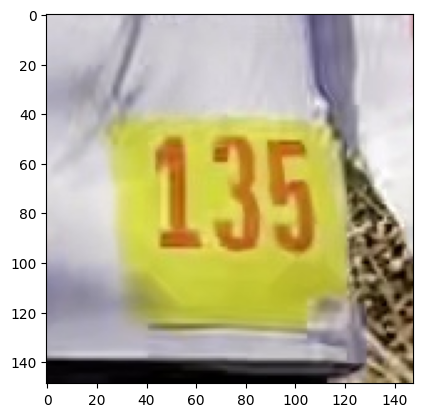

{'image': 'frame_00855.jpg', 'bib_number': '135', 'ocr_confidence': np.float64(0.9861290607126107), 'yolo_confidence': np.float32(0.84270006)}


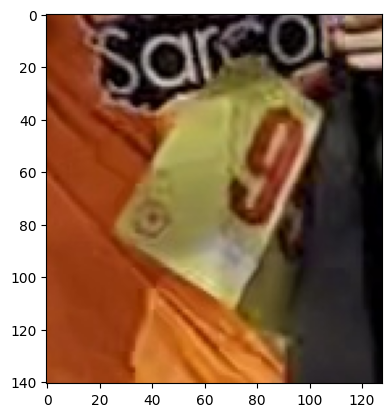

{'image': 'frame_00855.jpg', 'bib_number': '5', 'ocr_confidence': np.float64(0.14076956349640923), 'yolo_confidence': np.float32(0.794889)}


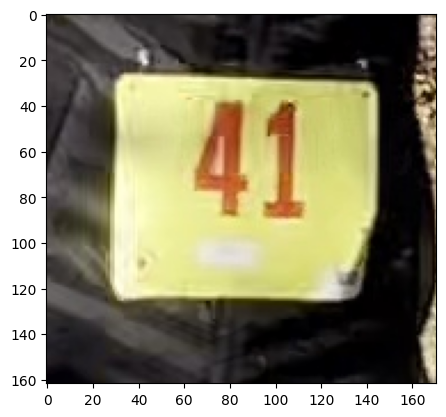

{'image': 'frame_00870.jpg', 'bib_number': '41', 'ocr_confidence': np.float64(0.999975976380869), 'yolo_confidence': np.float32(0.83992463)}


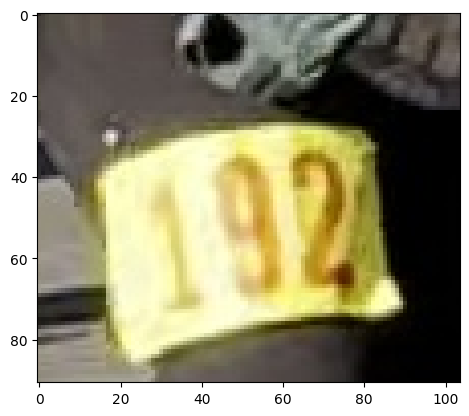

{'image': 'frame_00913.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.5035963)}


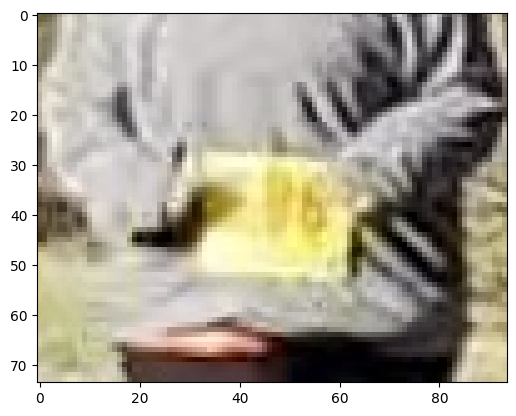

{'image': 'frame_00912.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.49563053)}


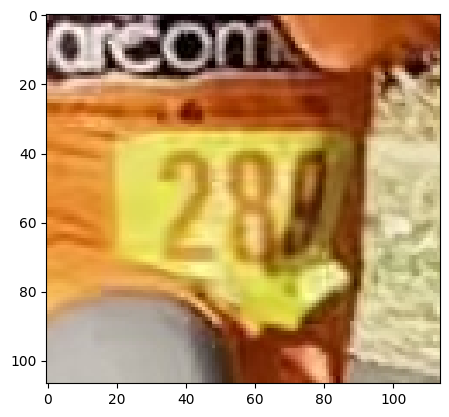

{'image': 'frame_00876.jpg', 'bib_number': '060', 'ocr_confidence': np.float64(0.10545816826813481), 'yolo_confidence': np.float32(0.7112942)}


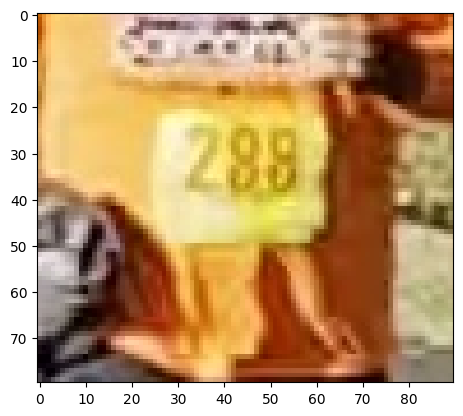

{'image': 'frame_00876.jpg', 'bib_number': '298', 'ocr_confidence': np.float64(0.7623891132939112), 'yolo_confidence': np.float32(0.39912835)}


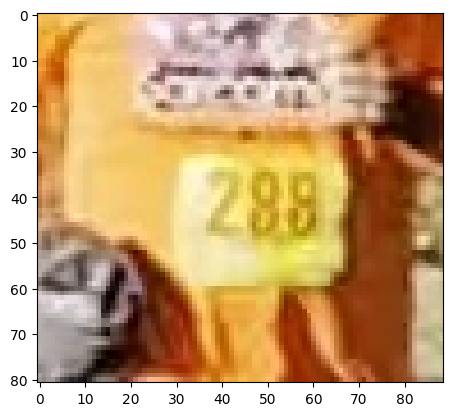

{'image': 'frame_00876.jpg', 'bib_number': '00', 'ocr_confidence': np.float64(0.4512450877687706), 'yolo_confidence': np.float32(0.3502083)}


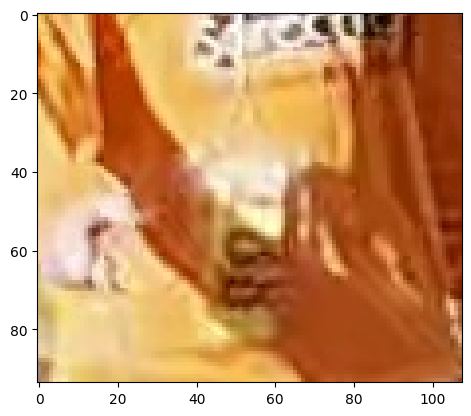

{'image': 'frame_00916.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.46403533)}


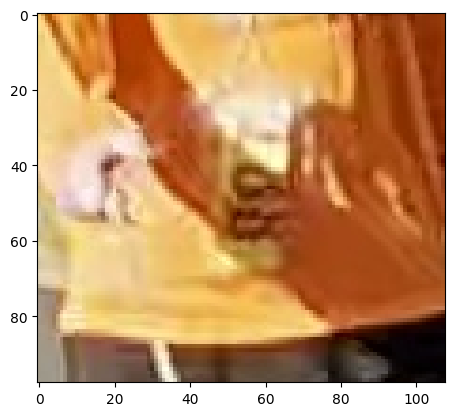

{'image': 'frame_00916.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.29977456)}


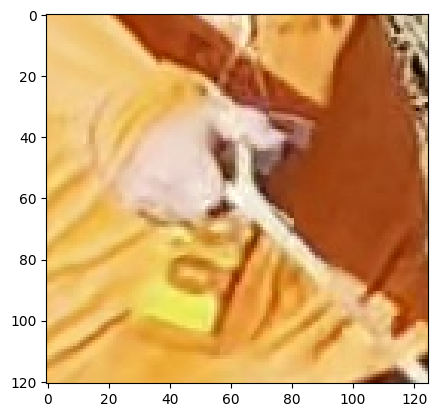

{'image': 'frame_00917.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.430259)}


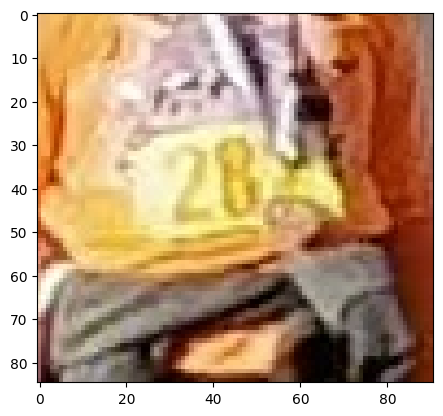

{'image': 'frame_00718.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.5593699)}


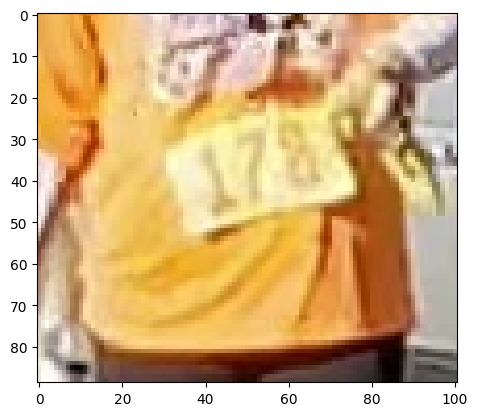

{'image': 'frame_00718.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.46386644)}


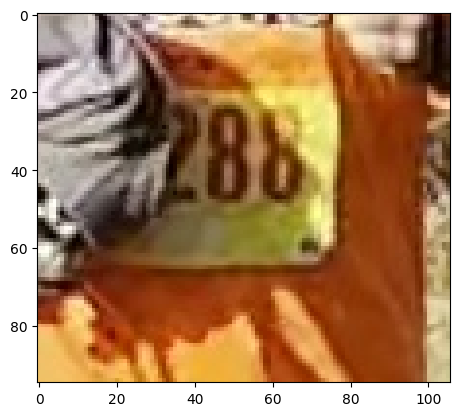

{'image': 'frame_00877.jpg', 'bib_number': '1286', 'ocr_confidence': np.float64(0.24246808886528015), 'yolo_confidence': np.float32(0.3967985)}


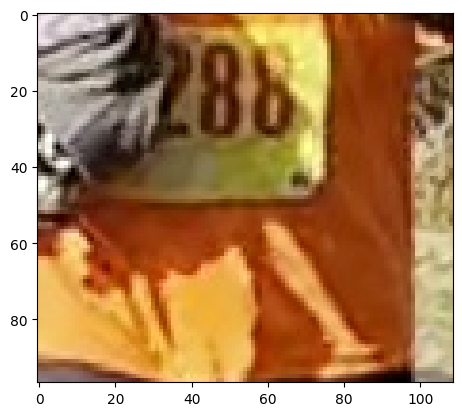

{'image': 'frame_00877.jpg', 'bib_number': '7286', 'ocr_confidence': np.float64(0.332715779542923), 'yolo_confidence': np.float32(0.3363281)}


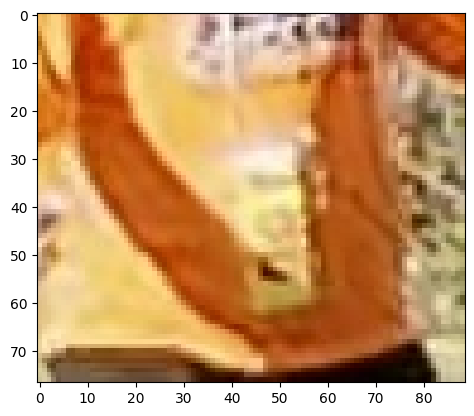

{'image': 'frame_00915.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.27895924)}


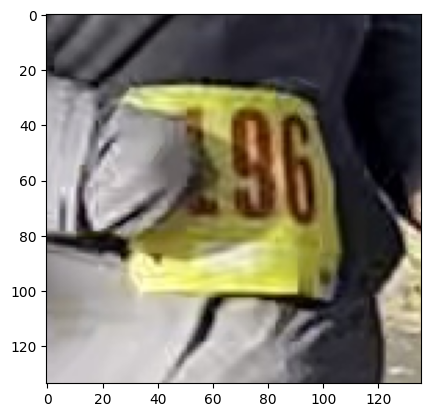

{'image': 'frame_00914.jpg', 'bib_number': '90', 'ocr_confidence': np.float64(0.7425766993493965), 'yolo_confidence': np.float32(0.83694553)}


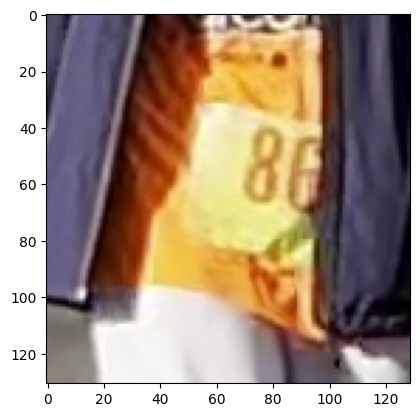

{'image': 'frame_00797.jpg', 'bib_number': '86', 'ocr_confidence': np.float64(0.39029592179914213), 'yolo_confidence': np.float32(0.7928765)}


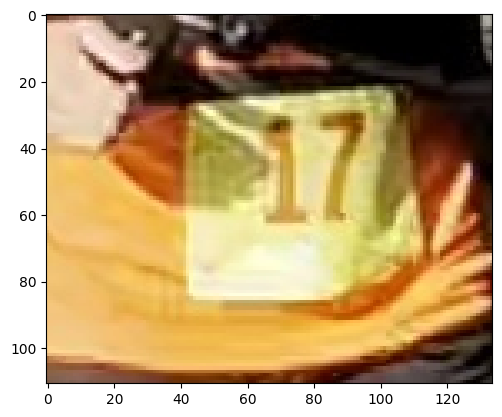

{'image': 'frame_00791.jpg', 'bib_number': '17', 'ocr_confidence': np.float64(0.3416080093059449), 'yolo_confidence': np.float32(0.7049057)}


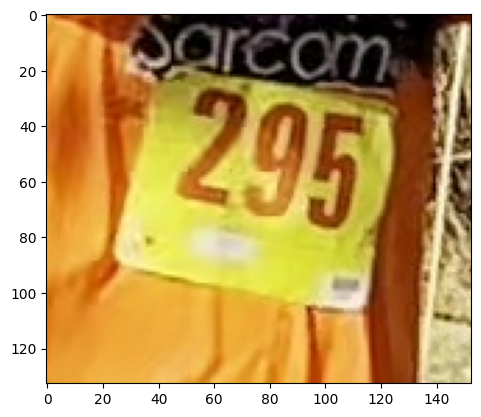

{'image': 'frame_00790.jpg', 'bib_number': '3', 'ocr_confidence': np.float64(0.12309849407989848), 'yolo_confidence': np.float32(0.8437178)}


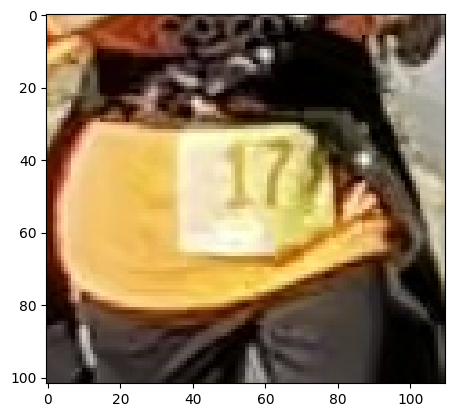

{'image': 'frame_00790.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.6902096)}


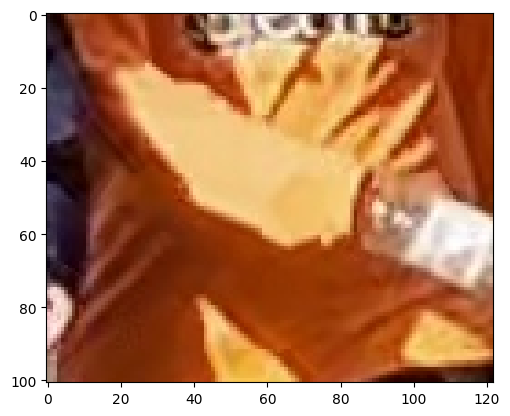

{'image': 'frame_00974.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.42529622)}


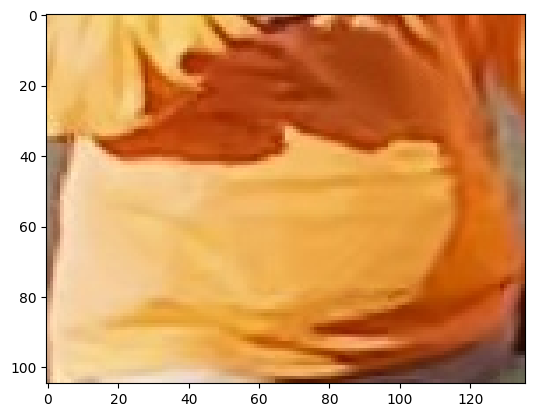

{'image': 'frame_00974.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.350983)}


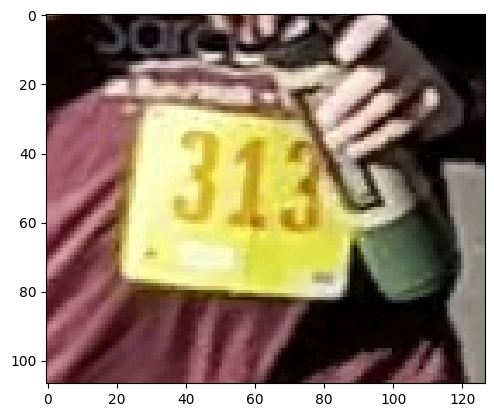

{'image': 'frame_00988.jpg', 'bib_number': '313', 'ocr_confidence': np.float64(0.9877100820528296), 'yolo_confidence': np.float32(0.86457354)}


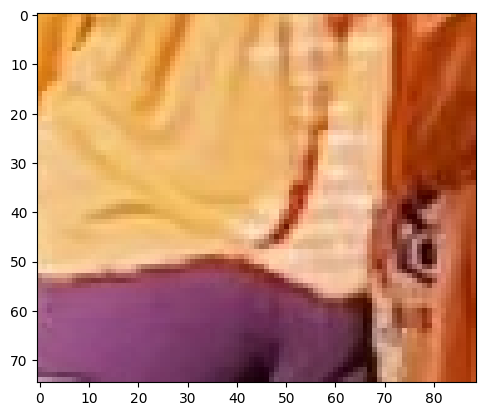

{'image': 'frame_00988.jpg', 'bib_number': None, 'ocr_confidence': None, 'yolo_confidence': np.float32(0.304833)}
Collected 37 bib crops for OCR analysis
Successfully read 19 bib numbers


In [147]:
# Collect bib predictions and apply OCR
print("Collecting bib predictions for OCR analysis...")

bib_crops_with_ocr = []
ocr_results = []

# Process a subset of images to collect bib predictions
for image_path in image_files_with_labels:  # Process first 10 images
    # Load image
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run inference
    results = model(str(image_path), conf=0.25, verbose=False)
    predictions = results[0] if results else None
    
    if predictions and len(predictions.boxes) > 0:
        
        boxes = predictions.boxes.xyxy.cpu().numpy()
        classes = predictions.boxes.cls.cpu().numpy()
        confidences = predictions.boxes.conf.cpu().numpy()
        
        for box, cls, conf in zip(boxes, classes, confidences):
            class_name = model.names.get(int(cls), f"Class {int(cls)}")
            
            # Focus on bib predictions (assuming class 0 is bib)
            if int(cls) == 1:  # Bib class
                # Crop the bib region
                bib_crop = crop_bib_from_prediction(image_rgb, box, padding=15)
                
                if bib_crop.size > 0:
                    plt.imshow(bib_crop)
                    plt.show()
                    # Apply OCR
                    # bib_number, ocr_confidence = extract_bib_number(bib_crop)
                    bib_number, ocr_confidence = extract_bib_with_easyocr(bib_crop)
                    bib_crops_with_ocr.append({
                        'image_name': image_path.name,
                        'crop': bib_crop,
                        'yolo_confidence': conf,
                        'bib_number': bib_number,
                        'ocr_confidence': ocr_confidence,
                        'bbox': box
                    })
                    
                    ocr_results.append({
                        'image': image_path.name,
                        'bib_number': bib_number,
                        'ocr_confidence': ocr_confidence,
                        'yolo_confidence': conf
                    })

                    print(ocr_results[-1])

print(f"Collected {len(bib_crops_with_ocr)} bib crops for OCR analysis")
print(f"Successfully read {len([r for r in ocr_results if r['bib_number']])} bib numbers")

In [141]:
# Display OCR results statistics
if ocr_results:
    successful_reads = [r for r in ocr_results if r['bib_number']]
    failed_reads = [r for r in ocr_results if not r['bib_number']]
    
    print(f"\nOCR Results Summary:")
    print(f"Total bib detections: {len(ocr_results)}")
    print(f"Successful OCR reads: {len(successful_reads)} ({len(successful_reads)/len(ocr_results)*100:.1f}%)")
    print(f"Failed OCR reads: {len(failed_reads)} ({len(failed_reads)/len(ocr_results)*100:.1f}%)")
    
    if successful_reads:
        ocr_confidences = [r['ocr_confidence'] for r in successful_reads]
        yolo_confidences = [r['yolo_confidence'] for r in successful_reads]
        
        print(f"\nOCR Confidence Statistics:")
        print(f"  Mean OCR confidence: {np.mean(ocr_confidences):.1f}%")
        print(f"  Median OCR confidence: {np.median(ocr_confidences):.1f}%")
        print(f"  Min OCR confidence: {np.min(ocr_confidences):.1f}%")
        print(f"  Max OCR confidence: {np.max(ocr_confidences):.1f}%")
        
        print(f"\nYOLO Confidence Statistics:")
        print(f"  Mean YOLO confidence: {np.mean(yolo_confidences):.1f}%")
        print(f"  Median YOLO confidence: {np.median(yolo_confidences):.1f}%")
        print(f"  Min YOLO confidence: {np.min(yolo_confidences):.1f}%")
        print(f"  Max YOLO confidence: {np.max(yolo_confidences):.1f}%")


OCR Results Summary:
Total bib detections: 37
Successful OCR reads: 19 (51.4%)
Failed OCR reads: 18 (48.6%)

OCR Confidence Statistics:
  Mean OCR confidence: 0.5%
  Median OCR confidence: 0.5%
  Min OCR confidence: 0.1%
  Max OCR confidence: 1.0%

YOLO Confidence Statistics:
  Mean YOLO confidence: 0.7%
  Median YOLO confidence: 0.8%
  Min YOLO confidence: 0.3%
  Max YOLO confidence: 0.9%


KeyError: 'crop'

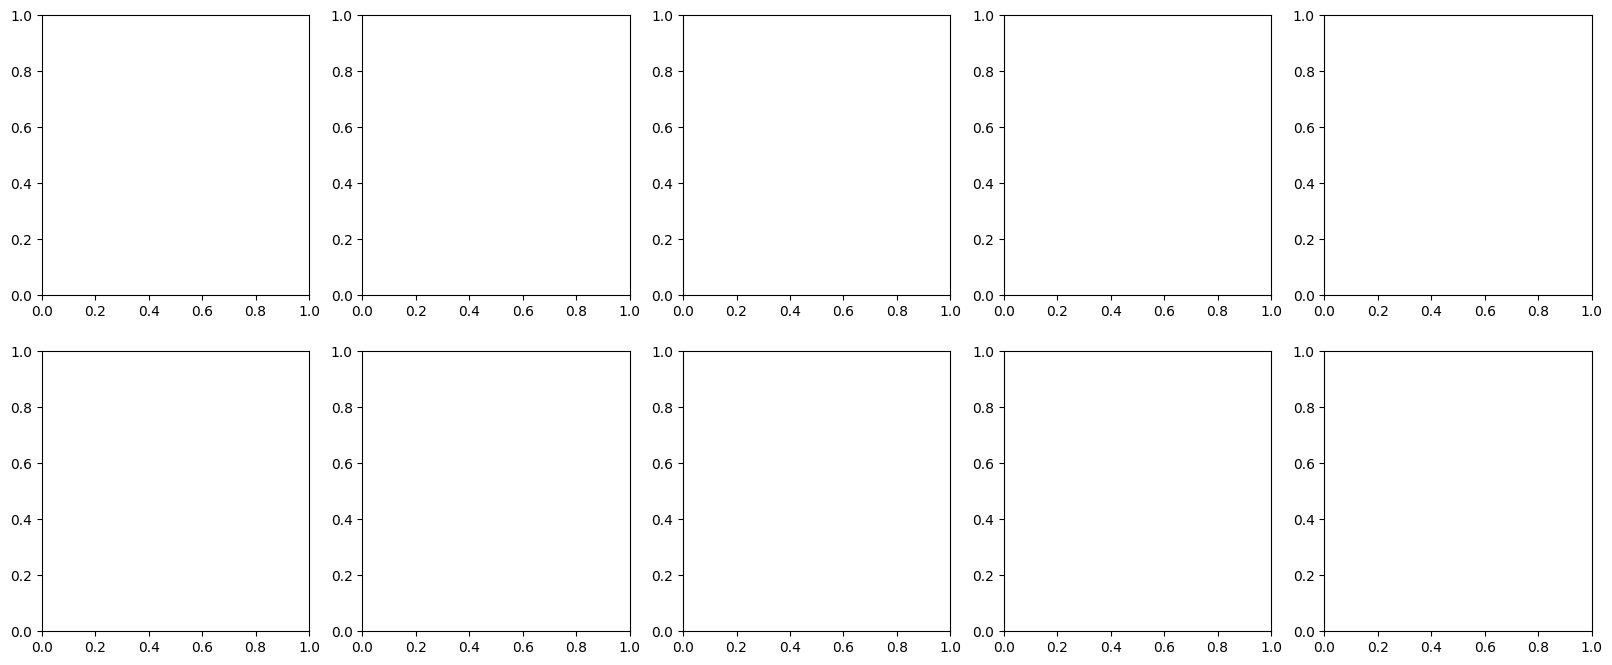

In [142]:
# Display some OCR results
if successful_reads:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, result in enumerate(successful_reads[:10]):
        crop = result['crop']
        bib_number = result['bib_number']
        ocr_confidence = result['ocr_confidence']
        yolo_confidence = result['yolo_confidence']
        
        axes[idx].imshow(crop)
        axes[idx].set_title(f"Bib: {bib_number}\nOCR Conf: {ocr_confidence}%\nYOLO Conf: {yolo_confidence}%")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful OCR reads to display.")

## Conclusion

This notebook demonstrated how to run inference on a trained YOLO model, visualize predictions, and analyze OCR results on bib numbers. The results show the model's performance on validation data and the effectiveness of OCR in reading bib numbers.